In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, validation_curve, KFold


In [92]:
train = pd.read_csv('./data/onetwotrip_challenge_train.csv')
test = pd.read_csv('./data/onetwotrip_challenge_test.csv')

In [93]:
def get_features(df):
    df['days_from_last_order'] = np.log(train['field0'] + 1) 
    df['order_price'] = np.log(df['field1'] / 0.07757136 + 1.10765391 * 10)
    df['order_month'] = df['field2']
    df['flight_month'] = df['field3']
    df['order_num'] = np.log(df['field4'] + 1) #other
    df['is_promo'] = df['field5']   
       
    df['days_to_flight'] = np.log(df['field16'] + 1)
    df['week_day'] = df['field18']
    df['week_day_flight'] = df['field20']
    df['hour'] = df['field11']
    df['year'] = df['field21']
    df['quarter'] = df['field29']
    
    df['num_tickets'] = df['field15']
    df['num_tickets_baby'] = df['field9']
    df['num_tickets_adult'] = df['field24']
    df['num_tickets_teen'] = df['field28']
    
    df['baby_ratio'] = df['num_tickets_baby'] / df['num_tickets']
    df['adult_ratio'] = df['num_tickets_adult'] / df['num_tickets']
    df['teen_ratio'] = df['num_tickets_teen'] / df['num_tickets']
    
    df['field12_log'] = np.log(train['field12'] + 1)
    df['field13_log'] = np.log(train['field13'] + 1)
    df['field14_log'] = np.log(train['field14'] + 1)
    df['field17_log'] = np.log(train['field17'] + 1)
    df['field22_log'] = np.log(train['field22'] + 1)
    df['field25_log'] = np.log(train['field25'] + 1)
    df['filed26_log'] = np.log(train['field26'] + 1)    
    df['field6_is_zero'] = df['field6'].map(lambda x: int(x == 0))

    user_agg_means = df.groupby(['userid'])[features_float].mean().reset_index()
    user_agg_means.columns = [x for x in \
                              map(lambda x: x if (x == 'userid') else \
                                  'user_mean_' + x, user_agg_means.columns)]
    
    user_orders_count = train.groupby(['userid'])['orderid'].count().reset_index()
    
    user_orders_count.columns = ['userid', 'user_order_count']
    df = df.merge(user_agg_means, on='userid').merge(user_orders_count, on='userid')
    return df

In [135]:
features_float = ['days_from_last_order', 'order_price', 'days_to_flight',
                  'num_tickets', 'baby_ratio', 'adult_ratio', 'teen_ratio',
                  'field12_log', 'field13_log', 'field14_log', 'field17_log',
                  'field22_log', 'field25_log', 'filed26_log']

features_cat = ['order_month', 'flight_month', 
                'week_day_flight', 'week_day', 
                'year', 'quarter', 'hour',
                'field19', 'field23', 'field27']

features_binary = ['is_promo', 'field6_is_zero',
                   'field10', 'field7', 'field8',
                   'indicator_goal21', 'indicator_goal22',
                   'indicator_goal23', 'indicator_goal24',
                   'indicator_goal25']
target = 'goal1'
targets = ['goal21', 'goal22', 'goal23', 'goal24', 'goal25', 'goal1']

In [95]:
train = get_features(train)

In [136]:
from sklearn.model_selection import train_test_split

X, y = train[features_float + features_cat + features_binary + ['field6']], train[target]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
params =  {'n_estimators': 203,
          'boosting_type': 'gbdt',
            'class_weight': None,
            'colsample_bytree': 0.3811304824216669,
            'importance_type': 'split',
            'learning_rate': 0.016659893432998896,
            'max_depth': 20,
            'metric': ['logloss', 'auc'],
            'min_child_samples': 12,
            'min_child_weight': 0.0036350360157623163,
            'min_split_gain': 0.9619961904304549,
            'n_jobs': -1,
            'num_leaves': 32,
            'objective': 'binary',
            'reg_alpha': 0.8022751137716411,
            'reg_lambda': 0.8186913351852023,
            'silent': True,
            'subsample': 0.5967826661188248,
            'subsample_for_bin': 200000,
            'subsample_freq': 14
    }

model = lgb.LGBMClassifier(**params) 

In [158]:
# cross validation
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print(scores)

print("score in ({}, {})" \
      .format(scores.mean() - scores.std(), scores.mean() + scores.std()))

[0.70171253 0.70134761 0.68947321 0.6859099  0.65768092]
score in (0.6711688512479228, 0.7032808165214357)


In [170]:
params =  {'n_estimators': 300,
          'boosting_type': 'gbdt',
            'class_weight': None,
            'colsample_bytree': 0.3811304824216669,
            'importance_type': 'split',
            'learning_rate': 0.016659893432998896,
            'max_depth': 7,
            'metric': ['logloss', 'auc'],
            'min_child_samples': 12,
            'min_child_weight': 0.0036350360157623163,
            'min_split_gain': 0.9619961904304549,
            'n_jobs': -1,
            'num_leaves': 32,
            'objective': 'binary',
            'reg_alpha': 0.8022751137716411,
            'reg_lambda': 0.8186913351852023,
            'silent': True,
            'subsample': 0.5967826661188248,
            'subsample_for_bin': 200000,
            'subsample_freq': 14
    }

model = lgb.LGBMClassifier(**params) 

In [171]:
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
print(scores)

print("score in ({}, {})" \
      .format(scores.mean() - scores.std(), scores.mean() + scores.std()))

[0.70391697 0.70162084 0.68852227 0.68381587 0.66113309]
score in (0.6724506408808011, 0.7031529692174936)


In [159]:
scores = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_on_this_split = cross_val_score(
            estimator=model, X=train_X, y=train_y,
            cv=fold, scoring='roc_auc')
    scores = np.append(scores, scores_on_this_split)

In [160]:
scores

array([0.69108615, 0.67993184, 0.68233435, 0.69616152, 0.68155834,
       0.68999358, 0.67744002, 0.68763392, 0.68925226, 0.68448002,
       0.69509705, 0.67710438, 0.68602952, 0.68837393, 0.68145066,
       0.69987275, 0.67254114, 0.68394459, 0.69568884, 0.68327277,
       0.68514585, 0.67651918, 0.67502871, 0.70308416, 0.6906283 ,
       0.68469669, 0.69285995, 0.6748058 , 0.68446697, 0.69214632,
       0.69930635, 0.68126065, 0.68451028, 0.69253593, 0.67687657,
       0.66732161, 0.70107218, 0.68140784, 0.67565094, 0.69281425,
       0.67895091, 0.68538086, 0.68929943, 0.68282661, 0.68757689,
       0.66817754, 0.70165635, 0.67884169, 0.69458388, 0.69025575])

In [161]:
print("score in ({}, {})" \
      .format(scores.mean() - scores.std(), scores.mean() + scores.std()))

score in (0.6774131296834965, 0.6943043135859376)


In [120]:
model.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.03, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=-1, nthread=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [121]:
for f, vs in zip(features_float + features_cat + features_binary + ['field6', 'order_num'],
                 model.feature_importances_):
    print('{} : {}'.format(f, vs))

days_from_last_order : 451
order_price : 514
days_to_flight : 641
num_tickets : 115
baby_ratio : 42
adult_ratio : 46
teen_ratio : 88
field12_log : 695
field13_log : 390
field14_log : 456
field17_log : 227
field22_log : 397
field25_log : 189
filed26_log : 272
order_month : 269
flight_month : 233
week_day_flight : 187
week_day : 236
year : 68
quarter : 1
hour : 438
field19 : 201
field23 : 381
field27 : 98
is_promo : 46
field6_is_zero : 40
field10 : 129
field7 : 23
field8 : 34
indicator_goal21 : 18
indicator_goal22 : 45
indicator_goal23 : 71
indicator_goal24 : 61
indicator_goal25 : 43
field6 : 285


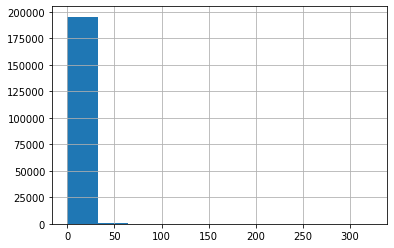

In [123]:
train['field6'].hist()

In [90]:
import numpy as np

def plot_targets(feature):
  
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(train[train[target] == 0][feature].map(lambda x: np.log(x + 1)),kde=False)
    plt.grid()
    plt.subplot(1, 2, 2)
    sns.distplot(train[train[target] == 1][feature].map(lambda x: np.log(x + 1)), color='r',kde=False)
    plt.grid()
    plt.show();

In [91]:
def plot_feature(feature):
    n_unique = train[feature].unique().shape[0]
    print('-------------------------------------')
    print('{} has {} values'.format(feature, n_unique))
    
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(train[feature])
    plt.grid()
    plt.subplot(1, 2, 2)
    sns.distplot(test[feature], color='r')
    plt.grid()
    plt.show();